---
Example of dataset

<table><tr><td>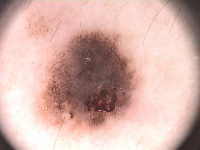</td><td>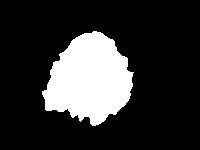</td></tr></table>



In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2021-04-13 20:36:38--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2021-04-13 20:36:39--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4b332eac22c830ed7cd3f43485.dl.dropboxusercontent.com/cd/0/inline/BMhtAqsJjazVEI1bro7tri_cUMDJA0LthPT_urY4pbMO_UmhmUCan2vn_OxLi0Rnr7m7fpj3X4zqFSbErhd9Kt3m0gqi5G6dhnpto2szPx-rtfcsPyStpzjdyf8JHz1vQvFhIiuhUMk_UUoPhnhSpULw/file# [following]
--2021-04-13 20:36:39--  https://uc4b332eac22c830ed7cd3f43485.dl.dropboxusercontent.com/cd/0/inline/BMhtAqsJjazVEI1bro7tri_cUMDJA0LthPT_urY4pbMO_UmhmUCan2vn_OxLi0Rnr7m7fpj3X4zqFSbErhd9

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Structure of dataset

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

To download we use skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

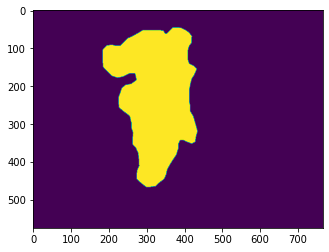

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
lesions[0].shape
plt.imshow(lesions[0])
plt.show();

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Samples:

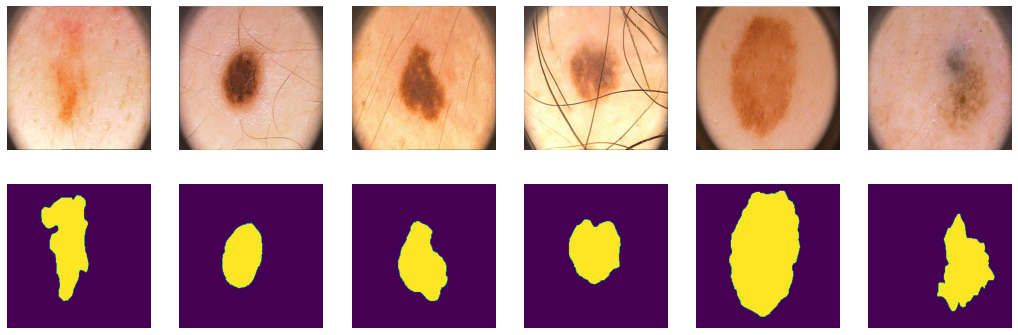

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Divide 200 pic's to 100/50/50 for validation and test

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
# for X,Y in data_tr:
#   print(X.shape)
#   for x in X:
#     print(x)
#     # plt.imshow(x.permute(1, 2, 0))
#     # plt.show()

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet [2 балла]

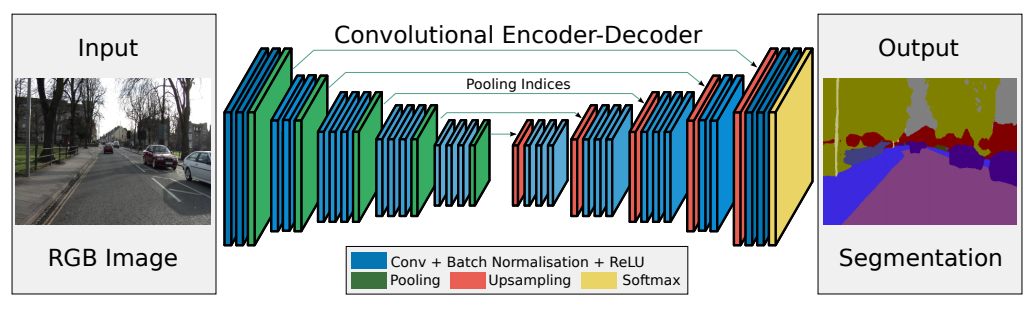

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Implementation of small SegNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
                        )

    def forward(self, x):
        x = x.to(device)

        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        
        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))  # no activation

        return d3

## Metric

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$



To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

In [ ]:
def bce_loss(y_real, y_pred):
    criterion = torch.nn.BCEWithLogitsLoss()
    return criterion(y_pred, y_real)
    print(y_pred.shape)
    print(y_real.shape)

## Training loop

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            data = model(X_batch.to(device))
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            # Y_pred = 
            loss =  bce_loss(Y_batch.to(device), data) # forward-pass
            
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        # Y_hat = Y_batch.detach().cpu()# detach and put into cpu
        Y_hat = model(X_val).detach().cpu()
        Y_target = Y_val.detach().cpu()
        test_loss = bce_loss(Y_target, Y_hat)
        test_losses.append(test_loss)
        # Visualize tools
        plt.figure(figsize=(18, 12))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_target[k, 0], cmap='gray')
            plt.title('Target')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return train_losses, test_losses

## Inference

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch)
        sigmoid = nn.Sigmoid()
        Y_pred = torch.tensor(sigmoid(Y_pred) > 0.5, dtype = torch.uint8)

        scores += metric(Y_pred.to(device), Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
model = SegNet().to(device)

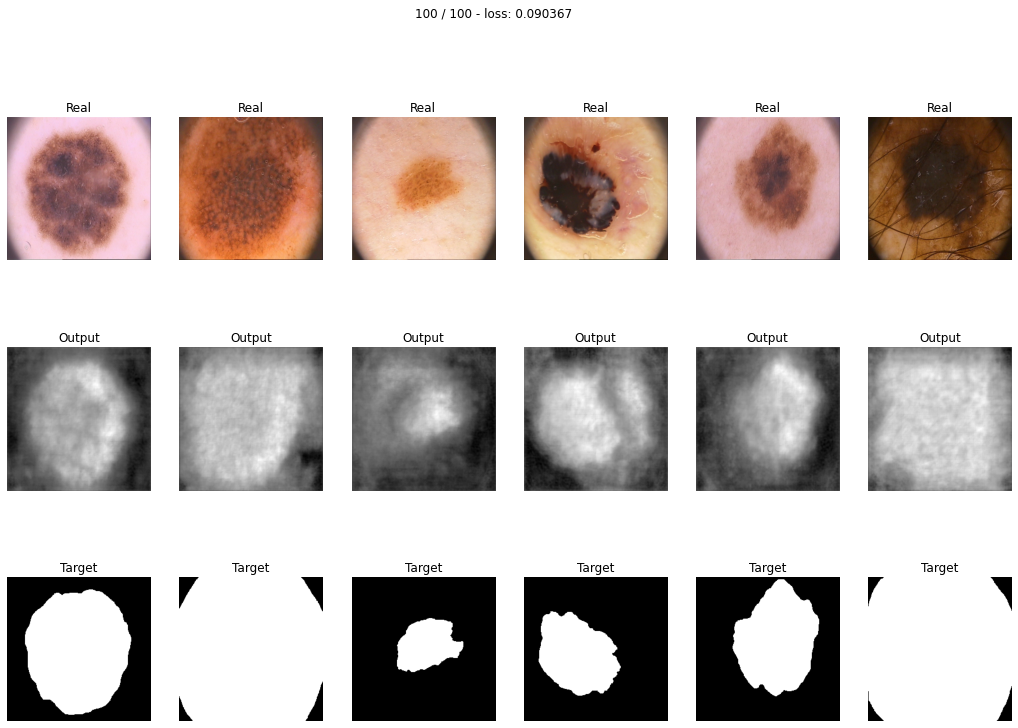

In [ ]:
import torch.optim as optim

max_epochs = 100
optim = torch.optim.AdamW(model.parameters())
train_losses, test_losses = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


0.506000030040741

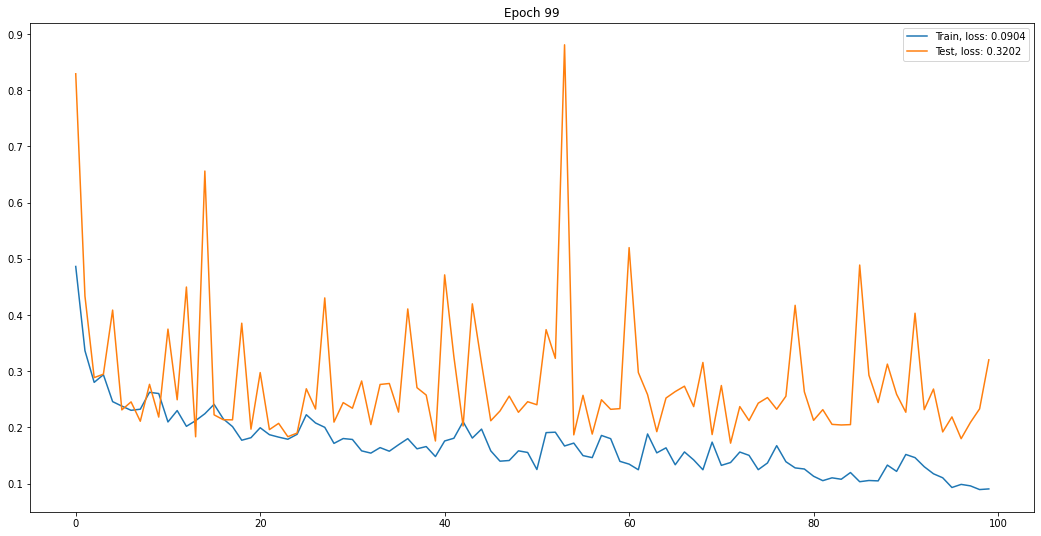

In [ ]:
plt.figure(figsize=(18, 9))
plt.plot(train_losses, label=f'Train, loss: {train_losses[-1]:.4f}')
plt.plot(test_losses, label=f'Test, loss: {test_losses[-1]:.4f}')
plt.title(f'Epoch {i}')
plt.legend(loc='best')
plt.show()